<a href="https://colab.research.google.com/github/DeMiKe16/RL_VLB/blob/main/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Definicion del problema

El ejercicio del Taxi en Gymnasium tiene como objetivo que un agente aprenda a transportar pasajeros de manera eficiente en un entorno de cuadrícula. El agente controla un taxi que debe recoger a un pasajero en una ubicación específica y llevarlo a su destino, navegando por calles y evitando obstáculos. El entorno simula un sistema de transporte donde el taxi debe moverse en cuatro direcciones (norte, sur, este, oeste) y realizar acciones adicionales como recoger y dejar al pasajero.

Un episodio en el Taxi finaliza en dos casos: si el taxi logra dejar al pasajero en su destino correctamente o si se supera un límite de pasos (generalmente 200).

Por cada paso, se otorga una recompensa basada en las siguientes reglas:

- Se otorga una recompensa de -1 por cada paso tomado, incentivando al agente a completar la tarea en la menor cantidad de movimientos posible.

- Se otorga una recompensa adicional de +20 cuando el pasajero es dejado en el destino correcto.

- Se aplica una penalización de -10 si el agente intenta recoger o dejar al pasajero en un lugar incorrecto.

Un episodio en el Taxi finaliza en dos casos:

- Éxito: Si el taxi recoge al pasajero en la ubicación correcta y lo deja en su destino de manera exitosa.

- Fracaso: Si se supera el límite de pasos permitidos (generalmente 200), lo que indica que el agente no logró completar la tarea en el tiempo establecido.

Estas dos condiciones definen las formas en que un episodio puede terminar, ya sea por cumplimiento del objetivo o por agotamiento del tiempo disponible.

# Autores
- Alejandro López Cuéllar
- Miguel Ángel Vera Frutos
- Alejandro Belda Fernández


# Importar librerías

In [ ]:
! git clone https://github.com/DeMiKe16/RL_VLB.git

In [ ]:
!pip install numpy matplotlib tqdm gymnasium moviepy torch

In [ ]:
#@title Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gymnasium as gym
import torch
import Box2D
import random
import os
import gc
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

# Reproducibilidad

In [ ]:
semilla = 42
np.random.seed(semilla)
np.random.default_rng(semilla)
random.seed(semilla)
os.environ['PYTHONHASHSEED'] = str(semilla)
torch.manual_seed(semilla)
if torch.cuda.is_available():
    torch.cuda.manual_seed(semilla)
    torch.cuda.manual_seed_all(semilla)  # Para múltiples GPUs

In [ ]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.empty_cache()

In [ ]:
gc.collect()

0

# Metodos Auxiliares

Este método nos genera una política óptima (`pi_star`) a partir de una función de valor de acción `Q(o los weights)` en un entorno, recorriendo el ambiente desde un estado inicial hasta que se alcanza un estado terminal o se trunca el episodio. Se inicializa el entorno con una semilla (que falta definir), y en cada paso, se selecciona la acción con el mayor valor Q calculado a partir de las características activas del estado actual. Se almacena la política óptima en un diccionario, registra la secuencia de acciones tomadas en una cadena y guarda las imágenes renderizadas en `frames`. Finalmente, devuelve la política óptima, la secuencia de acciones y la lista de imágenes del episodio.

In [ ]:
def pi_star_from_Q(env, Q):
    frames = []
    done = False
    pi_star = np.zeros([env.observation_space.n, env.action_space.n])
    state, info = env.reset(seed = semilla)
    img = env.render()
    frames.append(img)
    actions = ""
    while not done:
        q_values = Q[state]
        action = np.argmax(q_values)
        actions += f"{action}, "
        pi_star[state, action] = action
        state, reward, terminated, truncated, info = env.step(action)
        img = env.render()
        frames.append(img)
        done = terminated or truncated
    return pi_star, actions, frames

El metodo `plot` se encarga de generar gráficos para analizar el rendimiento de un agente de aprendizaje por refuerzo. Calcula la media móvil de la proporción de recompensas obtenidas y del tamaño de los episodios usando una ventana deslizante (`window_size`) para suavizar las fluctuaciones. Luego, en un gráfico de dos subgráficos, muestra la evolución de las recompensas y los tamaños de los episodios a lo largo del tiempo, comparando los valores originales con sus medias móviles para visualizar tendencias y estabilidad en el aprendizaje del agente. Finalmente, ajusta el diseño y muestra los gráficos.

In [ ]:
def plot(list_stats, episode_sizes, window_size=100):
    # Creamos una lista de índices para el eje x
    indices = list(range(len(list_stats)))

    # Función para calcular la media móvil
    def calculate_moving_avg(data, window_size):
        moving_avg = []
        for i in range(len(data)):
            if i < window_size:
                moving_avg.append(sum(data[:i+1]) / (i+1))
            else:
                moving_avg.append(sum(data[i-window_size:i+1]) / window_size)
        return moving_avg

    # Calculamos la media móvil para la proporción de recompensas
    moving_avg_rewards = calculate_moving_avg(list_stats, window_size)

    # Calculamos la media móvil para el tamaño del episodio
    moving_avg_sizes = calculate_moving_avg(episode_sizes, window_size)

    # Creamos el gráfico de la proporción de recompensas y la media móvil
    plt.figure(figsize=(12, 6))

    # Gráfico de la proporción de recompensas y la media móvil
    plt.subplot(2, 1, 1)
    plt.plot(indices, list_stats, label='Proporción de recompensas', alpha=0.3, color='blue')  # Más transparente
    plt.plot(indices, moving_avg_rewards, label=f'Media móvil (ventana={window_size})', color='red', linewidth=2)  # Más opaco
    plt.title('Proporción de recompensas y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Proporción')
    plt.legend()
    plt.grid(True)

    # Gráfico del tamaño del episodio y su media móvil
    plt.subplot(2, 1, 2)
    plt.plot(indices, episode_sizes, label='Tamaño del episodio', alpha=0.3, color='green')  # Más transparente
    plt.plot(indices, moving_avg_sizes, label=f'Media móvil (ventana={window_size})', color='orange', linewidth=2)  # Más opaco
    plt.title('Tamaño del Episodio y Media Móvil')
    plt.xlabel('Episodio')
    plt.ylabel('Tamaño')
    plt.legend()
    plt.grid(True)

    # Ajustamos el espacio entre los subplots
    plt.tight_layout()

    # Mostramos los gráficos
    plt.show()

El metodo `create_gif` se encarga de crear un gif a partir de una lista de imagenes, este gif sera un video en donde se ve si el agente entrenado previamente es capaz de completar el juego.

In [ ]:
def create_gif(frames: list, filename, fps=5):
   """
   Creates a GIF animation from a list of RGBA NumPy arrays.
   Args:
       frames: A list of RGBA NumPy arrays representing the animation frames.
       filename: The output filename for the GIF animation.
       fps: The frames per second of the animation (default: 10).
   """
   clip = ImageSequenceClip(frames, fps=fps)
   clip.write_videofile(filename, fps=fps)

Creamos el entorno de Taxi en su ultima versión.

In [ ]:
#@title Cargamos el entorno
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=semilla)

(386, {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)})

En este caso, vemos que el estado de acción va de 0 a 5:


- **0**: Mover hacia el **sur**.  
- **1**: Mover hacia el **norte**.  
- **2**: Mover hacia el **este**.  
- **3**: Mover hacia el **oeste**.  
- **4**: **Recoger** al pasajero.  
- **5**: **Dejar** al pasajero.  

In [ ]:
env.action_space

Discrete(6)

Y el estado de observación consta de 500 estados posibles:

1. **Posición del taxi**: El taxi se mueve en una cuadrícula de 5x5, lo que da un total de 25 posiciones posibles.
2. **Ubicación del pasajero**: El pasajero puede estar en una de las 5 ubicaciones posibles (4 puntos de recogida + 1 dentro del taxi).
3. **Destino del pasajero**: El pasajero tiene 4 destinos posibles a los que debe ser llevado.

La combinación de estas variables se calcula como:  
**25 (posiciones del taxi) × 5 (ubicaciones del pasajero) × 4 (destinos) = 500 estados posibles**.

In [ ]:
env.observation_space

Discrete(500)

# Q-Learning

Q-Learning es un algoritmo que utiliza una tabla llamada **Q**, donde cada entrada representa un estado y las acciones posibles, asignando un valor que indica la utilidad esperada de tomar esa acción en ese estado. En cada paso, el agente elige una acción según una estrategia de exploración, recibe una recompensa y actualiza el valor Q de la acción elegida basándose en la recompensa obtenida y la mejor acción futura.

In [ ]:
import numpy as np
from collections import defaultdict
import random

class QLearningAgent:
    def __init__(self, env, gamma, epsilon, alpha, epsilon_decay, min_epsilon):
        """Initialize agent.

        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """

        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))


    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    def update(self, state, action, reward, next_state, done):
        """Update the agent's knowledge using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]

        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            Qsa_next = np.max(self.Q[next_state])

        # Q-learning update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Definimos hiperparámetros para el agente que le permitan obtener una solución

In [ ]:
# Hiperparámetros
NUM_EPISODES = 3000
GAMMA = 0.99  # Factor de descuento
ALPHA = 0.01  # Tasa de aprendizaje
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.01

Inicializamos el agente

In [ ]:
# Inicializar el agente
agentQL = QLearningAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON,
    alpha=ALPHA
)

In [ ]:
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=semilla)
    done = False
    episode_reward = 0
    episode_steps = 0

    while not done:
        action = agentQL.get_action(obs)  # Cambiado de get_action a select_action para mantener consistencia
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Actualizar el agente
        agentQL.update(obs, action, reward, next_obs, terminated)  # Usando el método step definido anteriormente

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/step_display}, epsilon: {agentQL.epsilon}")
        stats = 0.0


 12%|█▏        | 358/3000 [00:01<00:07, 366.82it/s]

success: -242.88, epsilon: 0.01


 27%|██▋       | 823/3000 [00:01<00:02, 955.82it/s]

success: -104.47, epsilon: 0.01


 45%|████▍     | 1341/3000 [00:01<00:00, 1851.32it/s]

success: -31.42, epsilon: 0.01
success: 3.236666666666667, epsilon: 0.01
success: 7.473333333333334, epsilon: 0.01


 82%|████████▏ | 2446/3000 [00:02<00:00, 3060.02it/s]

success: 7.053333333333334, epsilon: 0.01
success: 7.593333333333334, epsilon: 0.01
success: 7.636666666666667, epsilon: 0.01


100%|██████████| 3000/3000 [00:02<00:00, 1266.35it/s]

success: 7.536666666666667, epsilon: 0.01


Como se puede ver, desde el principio para que va aprendiendo y mejorando su comportamiento, hasta que se mantiene en una recompensa de 7.5 aproximadamente.

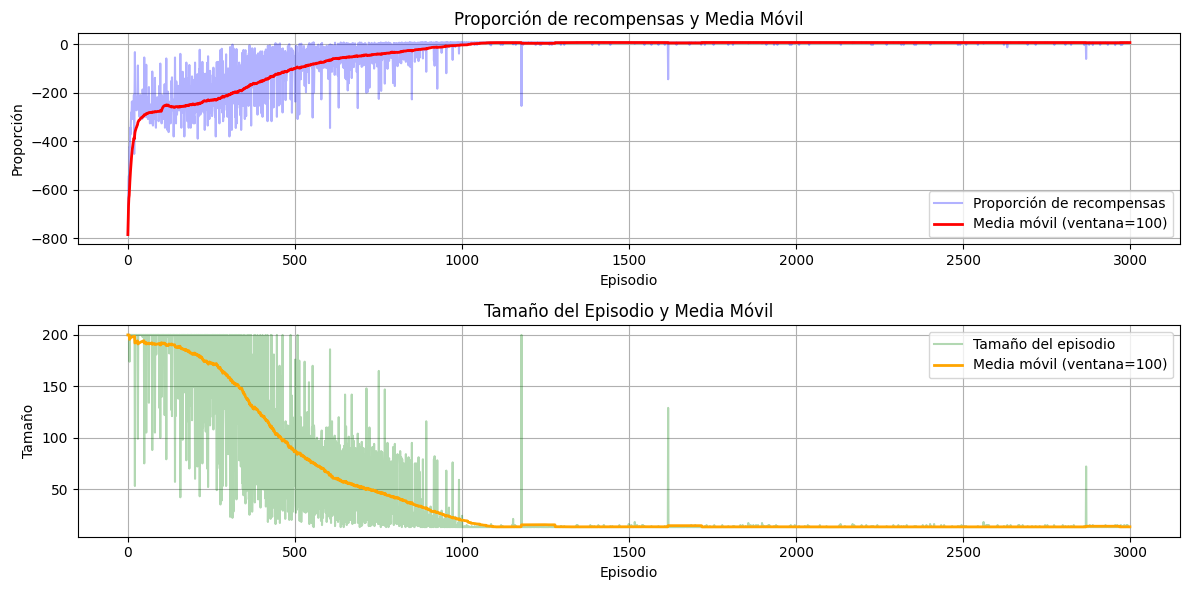

In [ ]:
plot(rewards_per_episode, episodes_sizes)

Como podemos ver, respecto a las recompensas, se ve que converge de manera veloz y se estabiliza sobre el episodio 1100, aunque se puede ver que a lo largo del entrenamiento hay pequeños saltos de recompensas, pero logra estabilizarse en todo momento.

Resoecto a los tamaños de los episodios, se puede ver que el tamaño de los episodios disminuye a lo largo del entrenamiento se una manera más lineal, que el tamaño de los episodios disminuya indica que el agente está aprendiendo a realizar la tarea en menos pasos, lo cual es un indicador de que el agente está mejorando su comportamiento.

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agentQL.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 4, 0, 3, 0, 3, 3, 3, 0, 0, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "Q-Learning-Taxi.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Q-Learning-Taxi.mp4.
MoviePy - Writing video Q-Learning-Taxi.mp4



MoviePy - Done !
MoviePy - video ready Q-Learning-Taxi.mp4


En este caso, se ve que el taxi realiza el número de acciones mínimas para llegar a su destino, por lo que ha conseguido que aprenda a realizar la tarea de la forma más eficiente posible (caso óptimo).

# Sarsa


El algoritmo SARSA (State-Action-Reward-State-Action) es un método de aprendizaje por refuerzo que permite al agente aprender a tomar decisiones optimizando una función de valor que estima la recompensa esperada al realizar una acción en un estado determinado. El agente elige una acción utilizando una política de exploración-explotación, recibe una recompensa, y observa el siguiente estado. Luego, el agente selecciona una nueva acción en ese estado y actualiza su estimación de la recompensa esperada, teniendo en cuenta la recompensa recibida y el valor de la acción elegida en el siguiente estado. Este proceso se repite durante varias iteraciones, permitiendo que el agente aprenda gradualmente una política que maximiza las recompensas a lo largo del tiempo.

Definimos el Sarsa Agente

In [ ]:
class SarsaAgent:
    def __init__(self, env, gamma, epsilon, alpha, epsilon_decay, min_epsilon):
        """Initialize agent.

        Params
        ======
        - env: Gymnasium environment
        - eps: exploration rate
        - gamma: discount factor
        - alpha: learning rate
        """

        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    def update(self, state, action, reward, next_state, next_action, done):
        """Update the agent's knowledge using the most recently sampled tuple.

        Params
        ======
        - state: the previous state of the environment
        - action: the agent's previous choice of action
        - reward: last reward received
        - next_state: the current state of the environment
        - done: whether the episode is complete (True or False)
        """
        # Current Q-value
        current = self.Q[state][action]

        # Next state's maximum Q-value
        if done:
            Qsa_next = 0  # Terminal state has no future value
        else:
            Qsa_next = self.Q[next_state][next_action]

        # Sarsa update
        target = reward + (self.gamma * Qsa_next)
        self.Q[state][action] = current + (self.alpha * (target - current))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Definimos el agente

In [ ]:
# Inicializar el agente
agentSarsa = SarsaAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON,
    alpha=ALPHA
)

Y realizamos el entrenamiento.

In [ ]:
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=semilla)
    done = False
    episode_reward = 0
    episode_steps = 0

    action = agentSarsa.get_action(obs)  # Cambiado de get_action a select_action para mantener consistencia

    while not done:
        next_obs, reward, terminated, truncated, info = env.step(action)

        next_action = agentSarsa.get_action(next_obs)

        # Actualizar el agente
        agentSarsa.update(obs, action, reward, next_obs, next_action, terminated)  # Usando el método step definido anteriormente

        # Actualizar estado y métricas
        obs = next_obs
        action = next_action
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats/(episode+1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/step_display}, epsilon: {agentQL.epsilon}")
        stats = 0.0


  0%|          | 0/3000 [00:00<?, ?it/s]

 14%|█▍        | 417/3000 [00:00<00:04, 550.45it/s]

success: -246.93, epsilon: 0.01


 25%|██▌       | 759/3000 [00:01<00:02, 998.21it/s]

success: -104.76, epsilon: 0.01
success: -32.55, epsilon: 0.01


 65%|██████▍   | 1939/3000 [00:01<00:00, 3068.81it/s]

success: 3.4366666666666665, epsilon: 0.01
success: 7.493333333333333, epsilon: 0.01
success: 7.323333333333333, epsilon: 0.01
success: 6.89, epsilon: 0.01


100%|██████████| 3000/3000 [00:01<00:00, 1666.69it/s]

success: 7.533333333333333, epsilon: 0.01
success: 7.266666666666667, epsilon: 0.01


Como en el caso, de Q-Learning, también se puede ver que el agente aprende de manera veloz y se estabiliza sobre el valor de 7.5 aproximadamente (dando bajones a 6.89 o 7.3).

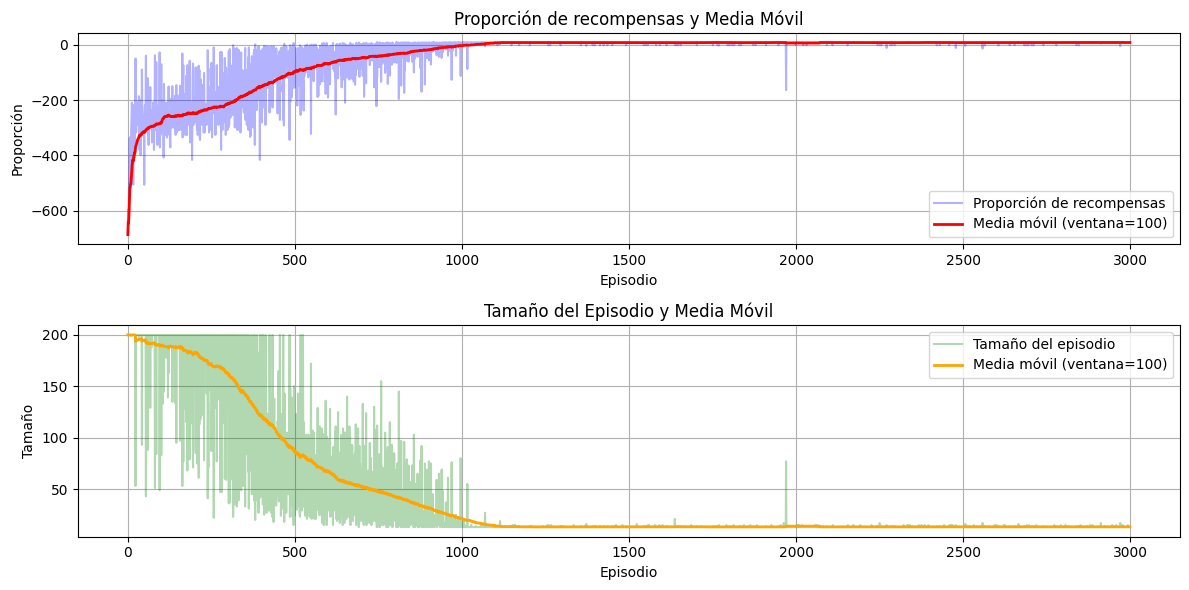

In [ ]:
plot(rewards_per_episode, episodes_sizes)

Se repite el comportamiento en las gráficas de recompensas y tamaños de episodios, se ve que el agente aprende de manera veloz y se estabiliza sobre el episodio 1100, aunque en este caso, se ve que es un poco más estable una vez converge el agente.

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agentSarsa.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 4, 0, 3, 3, 0, 3, 3, 0, 0, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "Sarsa-Taxi.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video Sarsa-Taxi.mp4.
MoviePy - Writing video Sarsa-Taxi.mp4



MoviePy - Done !
MoviePy - video ready Sarsa-Taxi.mp4


# Monte Carlo (Off-policy)

El algoritmo Monte Carlo Off-Policy es un enfoque de aprendizaje por refuerzo en el que el agente aprende una política de acción mediante la simulación de episodios, pero la política utilizada para generar las acciones es diferente a la política que está siendo aprendida. En este método, se utilizan las experiencias obtenidas de una política exploratoria  para actualizar los valores de una política objetivo. A lo largo de múltiples episodios, el agente calcula los retornos observados y utiliza estos valores para actualizar las estimaciones de la política objetivo sin seguirla directamente durante la ejecución.

Definimos el agente

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Clase MonteCarloOffPolicyAgent
class MonteCarloOffPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.C = np.zeros((self.env.observation_space.n, self.env.action_space.n))  # Suma de pesos de Importance Sampling

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo Off-Policy
    def update(self, episode):
        G = 0  # Retorno total
        W = 1  # Peso de Importance Sampling

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            self.C[state, action] += W
            self.Q[state, action] += (W / self.C[state, action]) * (G - self.Q[state, action])

            # Si la acción no es la óptima según la política objetivo, terminar el episodio
            if action != np.argmax(self.Q[state]):
                break

            W = W * 1.0 / (self.epsilon / self.env.action_space.n + (1 - self.epsilon) * (action == np.argmax(self.Q[state])))

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Inicializamos el agente

In [ ]:
# Inicializar el agente
agentMCOff = MonteCarloOffPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=semilla)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agentMCOff.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agentMCOff.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/step_display}, epsilon: {agentQL.epsilon}")
        stats = 0.0

 11%|█         | 326/3000 [00:01<00:11, 224.11it/s]

success: -731.3033333333333, epsilon: 0.01


 24%|██▍       | 735/3000 [00:02<00:04, 558.97it/s]

success: -573.0766666666667, epsilon: 0.01


 36%|███▋      | 1091/3000 [00:02<00:01, 1180.72it/s]

success: -89.18, epsilon: 0.01
success: -36.63, epsilon: 0.01


 61%|██████    | 1834/3000 [00:03<00:00, 2048.54it/s]

success: -15.593333333333334, epsilon: 0.01
success: -9.203333333333333, epsilon: 0.01


 82%|████████▏ | 2468/3000 [00:03<00:00, 2620.72it/s]

success: -0.9066666666666666, epsilon: 0.01
success: 2.6566666666666667, epsilon: 0.01
success: 4.22, epsilon: 0.01


100%|██████████| 3000/3000 [00:03<00:00, 880.62it/s] 


Aquí se puede observar que la convergencia es más lenta que en los métodos tabulares, pero tambíen se obtiene una recompensa aceptable.

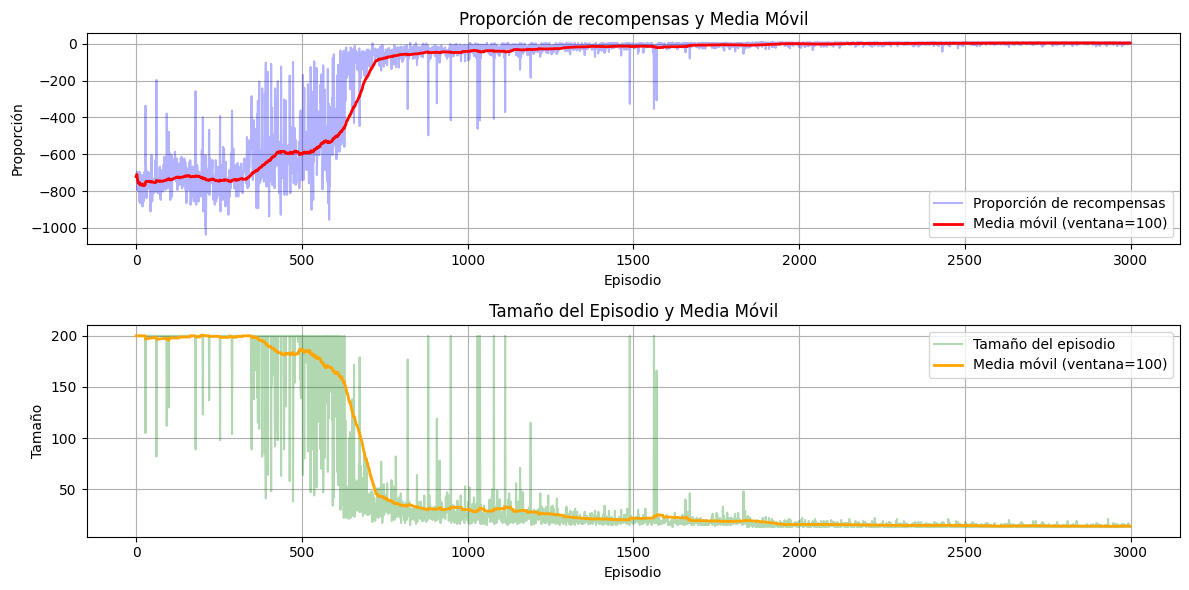

In [ ]:
plot(rewards_per_episode, episodes_sizes)

Aquí se puede apreciar la diferencia en cada tipo de método. En este caso, se ve que tarda más en converger que en Sarsa Y Q-Learning, esta durante más tiempo en un valor de recompensa malo, pero llega un momento en el que ya mejora y obtiene una casi neutra.

Respecto a los episodios, se ve que durante casi los primeros 500 episodios, se queda truncado en los 200 pasos, pero a partir de ahí, empieza a disminuir el tamaño de los episodios, lo cual indica que el agente está aprendiendo a realizar la tarea en menos pasos.

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agentMCOff.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 4, 3, 0, 0, 3, 3, 3, 0, 0, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "MCOffPolicy-Taxi.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOffPolicy-Taxi.mp4.
MoviePy - Writing video MCOffPolicy-Taxi.mp4



MoviePy - Done !
MoviePy - video ready MCOffPolicy-Taxi.mp4


# Monte Carlo (On-policy)

Monte Carlo on-policy es un algoritmo en donde el agente aprende una política directamente a partir de las experiencias obtenidas al interactuar con el entorno, sin necesidad de un modelo del mismo. En lugar de usar un valor Q  predefinido, el agente estima las recompensas futuras esperadas a través de simulaciones de episodios completos. En cada episodio, el agente sigue una política y al final del episodio, calcula la recompensa acumulada desde cada estado visitado. Luego, actualiza las estimaciones de valor de esos estados basándose en la media de las recompensas obtenidas en episodios previos. Este proceso se repite durante varios episodios, y el algoritmo ajusta su política para maximizar las recompensas acumuladas.

Definimos el agente

In [ ]:
import gymnasium as gym
import numpy as np
from tqdm import tqdm

# Clase MonteCarloOffPolicyAgent
class MonteCarloOnPolicyAgent:
    def __init__(self, env, gamma, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        self.Q = np.zeros((self.env.observation_space.n, self.env.action_space.n))

    # Política de comportamiento (ε-greedy)
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.env.action_space.n)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q[state])  # Explotación: mejor acción según Q

    # Actualizar la tabla Q usando Monte Carlo On-Policy
    def update(self, episode):
        G = 0  # Retorno total

        # Recorrer el episodio en reversa
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # Actualizar el Q-value para el par (state, action)
            self.Q[state, action] += (G - self.Q[state, action]) / (t + 1)  # Promedio incremental

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Inicializamos el agente con los valores por defecto

In [ ]:
# Inicializar el agente
agentMCOn = MonteCarloOnPolicyAgent(
    env=env,
    gamma=GAMMA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=semilla)
    done = False
    episode_reward = 0
    episode_steps = 0
    episode_data = []

    while not done:
        action = agentMCOn.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Guardar datos del episodio
        episode_data.append((obs, action, reward))

        # Actualizar estado y métricas
        obs = next_obs
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Actualizar el agente con el episodio completo
    agentMCOn.update(episode_data)

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/step_display}, epsilon: {agentQL.epsilon}")
        stats = 0.0

 12%|█▏        | 346/3000 [00:01<00:11, 231.55it/s]

success: -698.2733333333333, epsilon: 0.01


 25%|██▌       | 750/3000 [00:02<00:02, 800.80it/s]

success: -252.96333333333334, epsilon: 0.01


 41%|████      | 1220/3000 [00:02<00:01, 1302.92it/s]

success: -99.49666666666667, epsilon: 0.01
success: -87.78666666666666, epsilon: 0.01


 59%|█████▉    | 1782/3000 [00:02<00:00, 1655.63it/s]

success: -62.586666666666666, epsilon: 0.01
success: -32.07, epsilon: 0.01


 74%|███████▍  | 2216/3000 [00:02<00:00, 1620.74it/s]

success: -18.123333333333335, epsilon: 0.01


 93%|█████████▎| 2782/3000 [00:03<00:00, 1683.19it/s]

success: -134.58666666666667, epsilon: 0.01
success: -20.546666666666667, epsilon: 0.01


100%|██████████| 3000/3000 [00:03<00:00, 907.16it/s] 


En este caso, se puede ver que para On Policy Monte Carlo, no llega en converger en un valor positivo, pero si converge bastante.

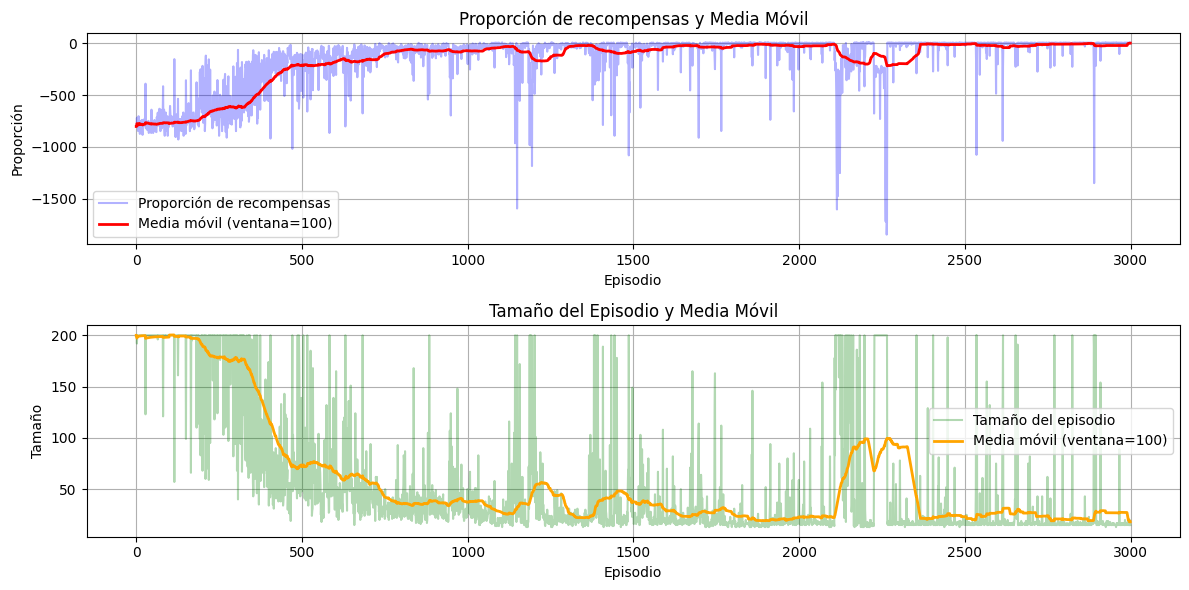

In [ ]:
plot(rewards_per_episode, episodes_sizes)

En este caso de Monte Carlo, si se puede observar que el aprendizaje es bastante mas inestable que en los otros métodos, ya que se ve que hay muchos saltos tanto en las recompensas como en el tamaño del episodio.

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agentMCOn.Q)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 3, 1, 2, 4, 3, 3, 0, 0, 3, 3, 0, 0, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "MCOnPolicy-Taxi.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video MCOnPolicy-Taxi.mp4.
MoviePy - Writing video MCOnPolicy-Taxi.mp4



MoviePy - Done !
MoviePy - video ready MCOnPolicy-Taxi.mp4


# Sarsa Semi-gradiente

**SARSA Semi-Gradiente** es un método de aprendizaje que se puedue usar cuando el espacio de estados es demasiado grande o continuo, lo que hace imposible almacenar una tabla de valores Q. En lugar de aprender directamente los valores de cada estado-acción, el algoritmo usa una función aproximadora (pesos) que estima estos valores basándose en un conjunto de parámetros ajustables. A medida que el agente explora el entorno, estos parámetros se actualizan de manera incremental utilizando descenso de gradiente, lo que permite mejorar la estimación de los valores de acción sin necesidad de almacenar todas las combinaciones posibles.

Definimos el agente

In [ ]:
# Clase SarsaSemiGradientAgent
class SarsaSemiGradientAgent:
    def __init__(self, env, gamma, alpha, epsilon, epsilon_decay, min_epsilon):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon

        # Inicializar los pesos de la función de valor Q(s, a)
        self.num_states = env.observation_space.n
        self.num_actions = env.action_space.n
        self.weights = np.zeros((self.num_states, self.num_actions))  # Pesos para la aproximación lineal

    # Política ε-greedy
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)  # Exploración: acción aleatoria
        else:
            return np.argmax(self.Q(state))  # Explotación: mejor acción según Q

    # Aproximación lineal de Q(s, a)
    def Q(self, state):
        return self.weights[state]  # Q(s, a) = weights[s, a]

    # Actualizar los pesos usando SARSA Semi-Gradiente
    def update(self, state, action, reward, next_state, next_action, done):
        if done:
            target = reward  # Si el episodio termina, el valor objetivo es la recompensa inmediata
        else:
            target = reward + self.gamma * self.Q(next_state)[next_action]  # Valor objetivo para SARSA

        # Calcular el error temporal
        td_error = target - self.Q(state)[action]

        # Actualizar los pesos usando el gradiente
        self.weights[state, action] += self.alpha * td_error

        # Decaimiento de ε
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.min_epsilon)

Definimos hiperparámetros para el agente que le permitan obtener una solución

In [ ]:
# Hiperparámetros
NUM_EPISODES = 3000
GAMMA = 0.99  # Factor de descuento
ALPHA = 0.01  # Tasa de aprendizaje
EPSILON = 1.0  # Probabilidad de exploración
EPSILON_DECAY = 0.999
MIN_EPSILON = 0.01

Inicializamos el agente

In [ ]:
# Inicializar el agente
agentSarsaSemi = SarsaSemiGradientAgent(
    env=env,
    gamma=GAMMA,
    alpha=ALPHA,
    epsilon=EPSILON,
    epsilon_decay=EPSILON_DECAY,
    min_epsilon=MIN_EPSILON
)

In [ ]:
# Listas para guardar métricas
rewards_per_episode = []
episodes_sizes = []

# Para mostrar la evolución en el terminal y algún dato que mostrar
stats = 0.0
list_stats = [stats]
step_display = NUM_EPISODES // 10

# Bucle de entrenamiento
for episode in tqdm(range(NUM_EPISODES)):
    obs, info = env.reset(seed=semilla)
    done = False
    episode_reward = 0
    episode_steps = 0

    # Seleccionar la primera acción
    action = agentSarsaSemi.get_action(obs)

    while not done:
        # Tomar la acción y observar el siguiente estado y recompensa
        next_obs, reward, terminated, truncated, info = env.step(action)

        # Seleccionar la siguiente acción
        next_action = agentSarsaSemi.get_action(next_obs)

        # Actualizar el agente
        agentSarsaSemi.update(obs, action, reward, next_obs, next_action, terminated)

        # Actualizar estado y métricas
        obs = next_obs
        action = next_action
        done = terminated or truncated
        episode_reward += reward
        episode_steps += 1

    # Guardamos datos sobre la evolución
    stats += episode_reward
    list_stats.append(stats / (episode + 1))

    # Guardar métricas del episodio
    rewards_per_episode.append(episode_reward)
    episodes_sizes.append(episode_steps)

    # Para mostrar la evolución. Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
        print(f"success: {stats/step_display}, epsilon: {agentQL.epsilon}")
        stats = 0.0

 14%|█▎        | 412/3000 [00:00<00:04, 539.57it/s]

success: -244.87333333333333, epsilon: 0.01


 25%|██▌       | 754/3000 [00:01<00:02, 979.54it/s]

success: -108.58, epsilon: 0.01
success: -33.51, epsilon: 0.01


 58%|█████▊    | 1750/3000 [00:01<00:00, 2720.64it/s]

success: 2.8866666666666667, epsilon: 0.01
success: 7.55, epsilon: 0.01
success: 7.446666666666666, epsilon: 0.01
success: 6.38, epsilon: 0.01


 94%|█████████▎| 2808/3000 [00:01<00:00, 3205.26it/s]

success: 7.496666666666667, epsilon: 0.01
success: 7.4, epsilon: 0.01


100%|██████████| 3000/3000 [00:01<00:00, 1587.41it/s]


En este ultimo algoritmo, se ve que el aprendizaje es muy rapido y como en los métodos tabulares, se estabiliza en un valor de recompensa de 7.5 aproximadamente.

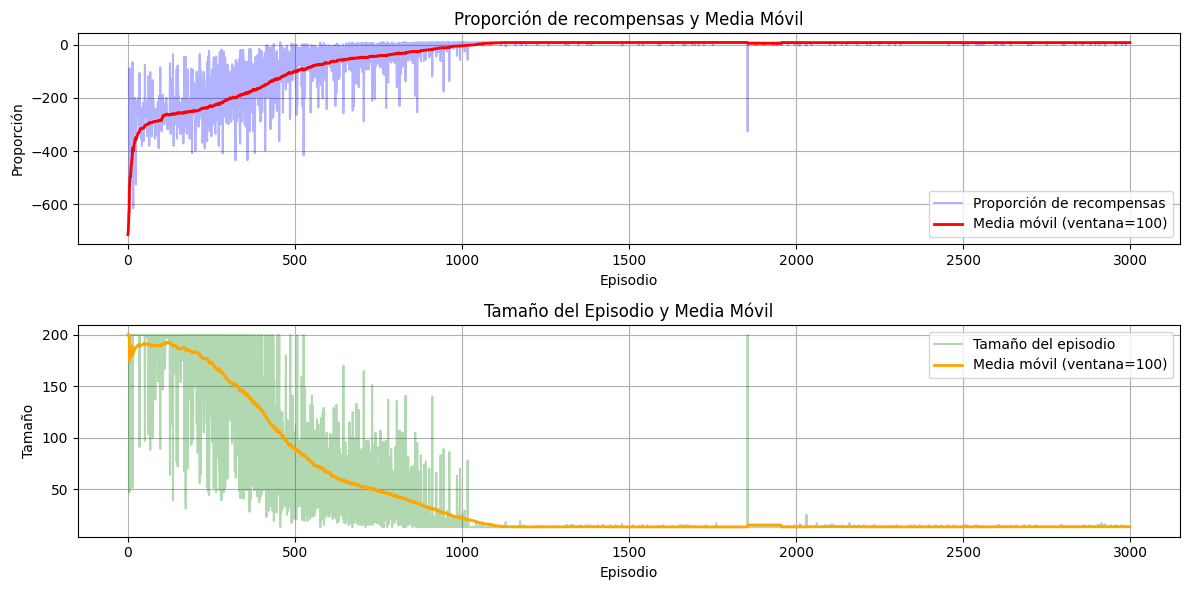

In [ ]:
plot(rewards_per_episode, episodes_sizes)

En estos gráficos, se puede ver que la convergencia es muy suave, además se ve que a lo largo del entrenamiento, el agente se mantiene estable a lo largo de los episodios y mantiene un comportamiento parecido a algoritmo homólogo Sarsa.

In [ ]:
pi, actions, frames = pi_star_from_Q(env, agentSarsaSemi.weights)

img = env.render()

frames.append(img)

print("Política óptima obtenida\n", pi, f"\n Acciones {actions} \n Para el siguiente grid\n", env.render() )
print()

Política óptima obtenida
 [[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]] 
 Acciones 1, 1, 1, 4, 0, 3, 0, 3, 3, 3, 0, 0, 5,  
 Para el siguiente grid
 [[[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[110 109 106]
  [110 109 106]
  [124 122 122]
  ...
  [108 111 109]
  [108 111 109]
  [118 119 119]]

 [[114 116 115]
  [114 116 115]
  [126 127 126]
  ...
  [112 113 111]
  [112 113 111]
  [118 117 115]]

 ...

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[116 115 116]
  [116 115 116]
  [106 107 108]
  ...
  [113 115 114]
  [113 115 114]
  [117 114 117]]

 [[115 112 112]
  [115 112 112]
  [119 119 117]
  ...
  [123 119 118]
  [123 119 118]
  [114 114 117]]]



In [ ]:
# Example usage
create_gif(frames, "SarsaSemiGradiente-Taxi.mp4", fps=1)  # saves the GIF locally

MoviePy - Building video SarsaSemiGradiente-Taxi.mp4.
MoviePy - Writing video SarsaSemiGradiente-Taxi.mp4



MoviePy - Done !
MoviePy - video ready SarsaSemiGradiente-Taxi.mp4
